In [1]:
%load_ext autoreload
%autoreload 2
%cd ../..

/Users/purzelrakete/src/github.com/feldberlin/wavenet


In [2]:
from pathlib import Path

import numpy as np
import torch
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd

from wavenet import model, utils, datasets, viz, audio

# Stereo Impulse Dataset

This dataset contains random synthetic sounds designed to be easy to inspect. The first sample is randomly drawn from a binomial distribution, and the following samples are zero.

In [3]:
ds = datasets.StereoImpulse(2**14, 5, model.HParams(), (0.3, 0.7))

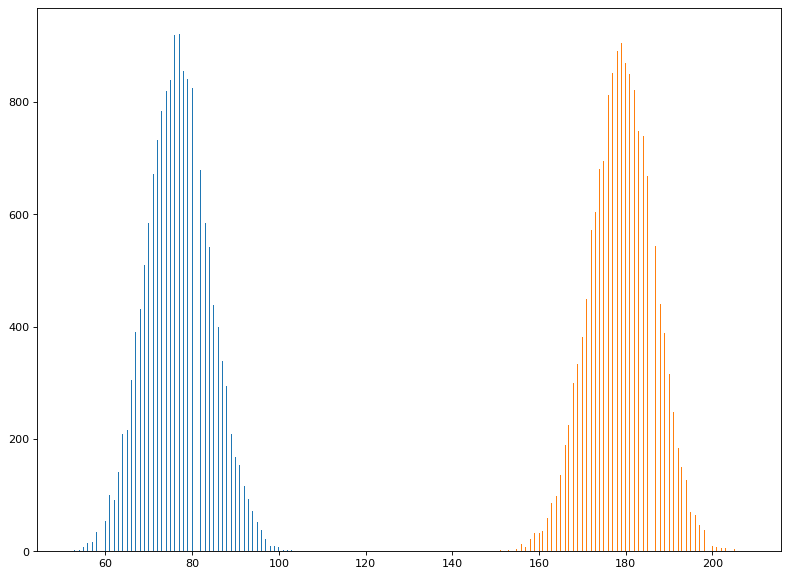

In [4]:
plt.figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
plt.hist(ds[:, 0, 0][1].numpy(), bins=256);
plt.hist(ds[:, 1, 0][1].numpy(), bins=256);

# Track Dataset

A dataset of slices taken from a single track.

## Uncompressed

Do not mu compress the data from 16 bit to 8 bit audio. We set `n_classes` to `2**16` to reflect the given bit depth since this affects the transforms applied to the dataset.

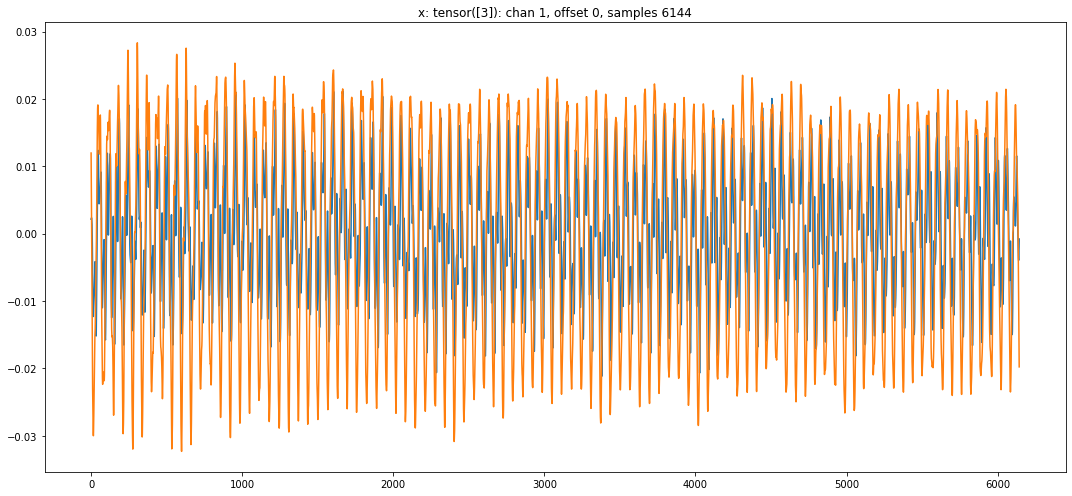

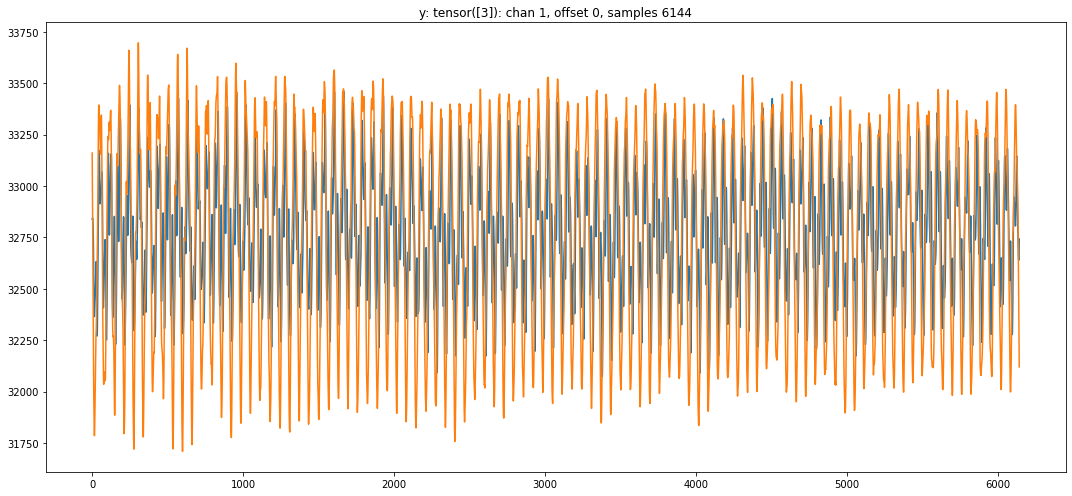

In [5]:
def track_dataset(compress=None, n_classes=None):
    p = model.HParams(compress=compress, n_classes=n_classes)
    ds = datasets.Track('fixtures/goldberg/short.wav', p)
    i, (x, y) = ds.sample()
    viz.plot_track(x[0], n_samples=p.receptive_field_size(), title=f'x: {i}')
    viz.plot_track(y[0], n_samples=p.receptive_field_size(), title=f'y: {i}')
    if p.compress: x = audio.mu_expand(x.numpy(), p)
    return ipd.Audio(x.squeeze(), rate=p.sampling_rate)
    
track_dataset(compress=False, n_classes=2**16)

## Compressed

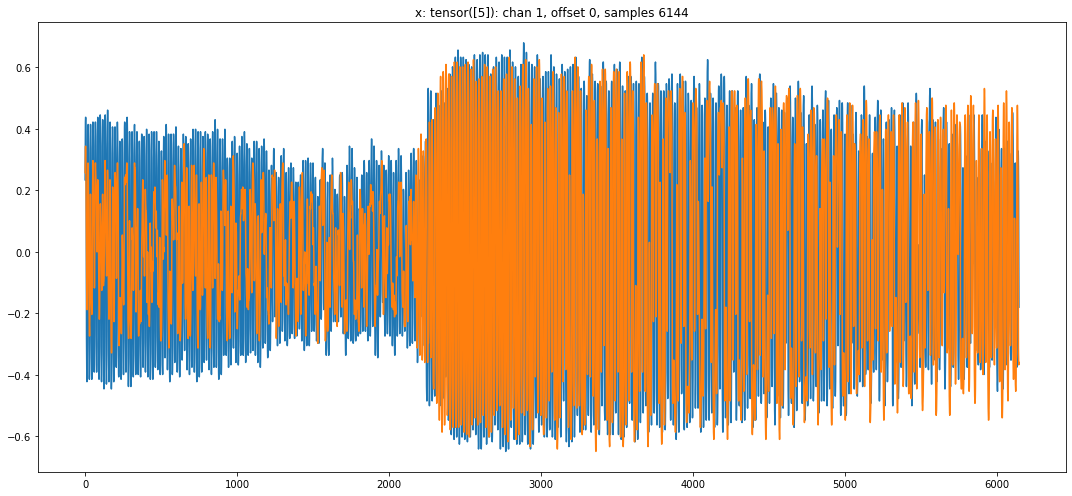

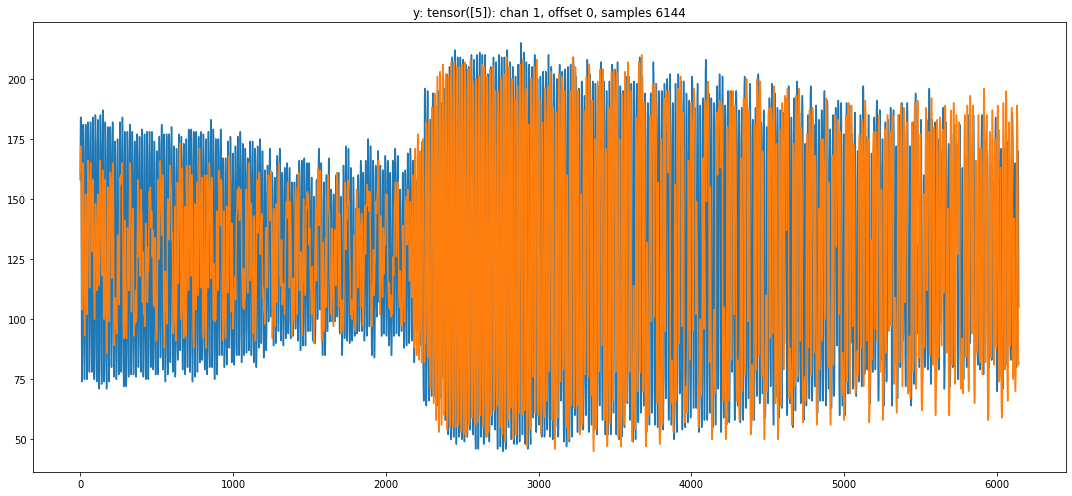

In [6]:
track_dataset(compress=True, n_classes=2**8)

# Tracks Dataset

A dataset of slices taken from many tracks.

## Uncompressed


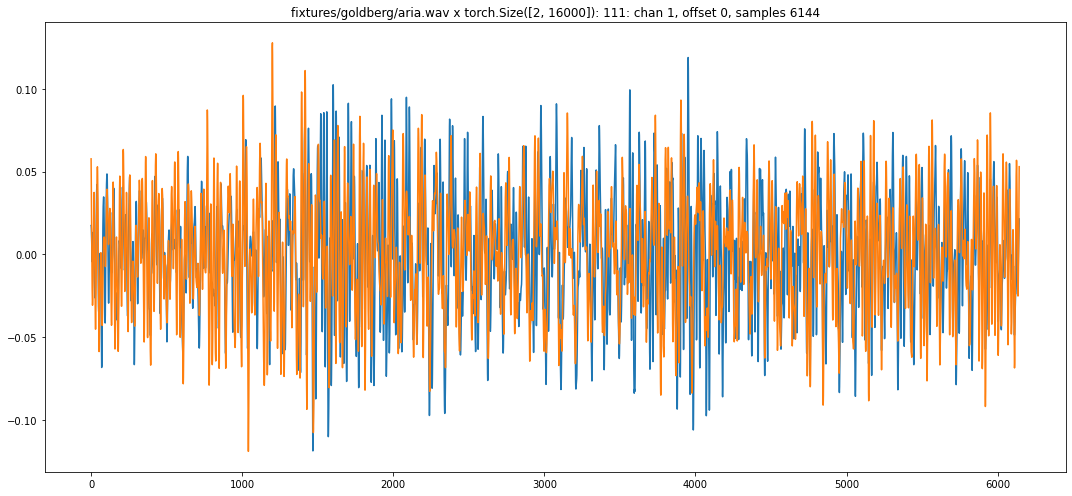

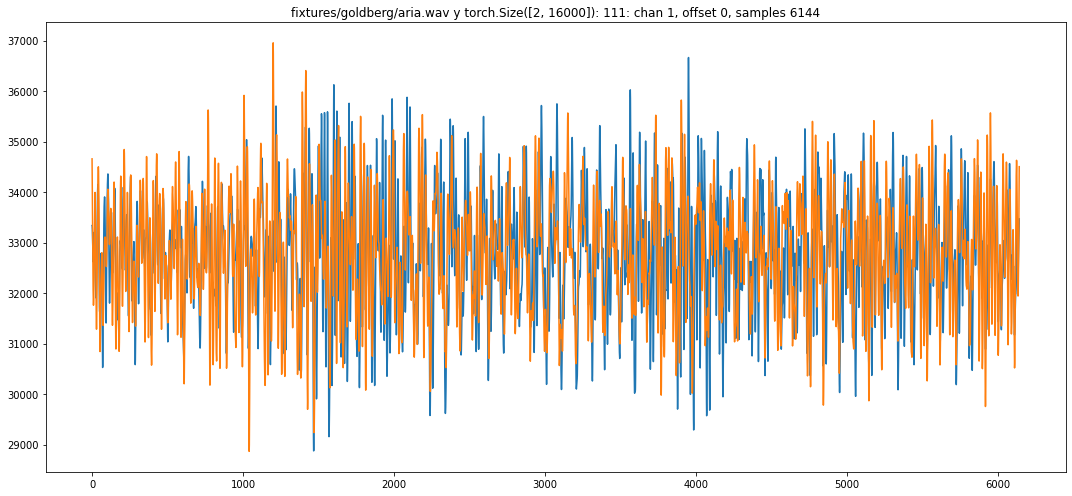

In [7]:
def tracks_dataset(compress=None, n_classes=None):
    p = model.HParams(compress=compress, n_classes=n_classes)
    ds = datasets.Tracks.from_dir(p, Path('fixtures/goldberg'))
    i, (x, y, track) = ds.sample()
    viz.plot_track(x, n_samples=p.receptive_field_size(), title=f"{track['path']} x {x.shape}: {i.item()}")
    viz.plot_track(y, n_samples=p.receptive_field_size(), title=f"{track['path']} y {y.shape}: {i.item()}")
    if p.compress: x = audio.mu_expand(x.numpy(), p)
    return ipd.Audio(x.squeeze(), rate=p.sampling_rate)
    
tracks_dataset(compress=False, n_classes=2**16)

## Compressed

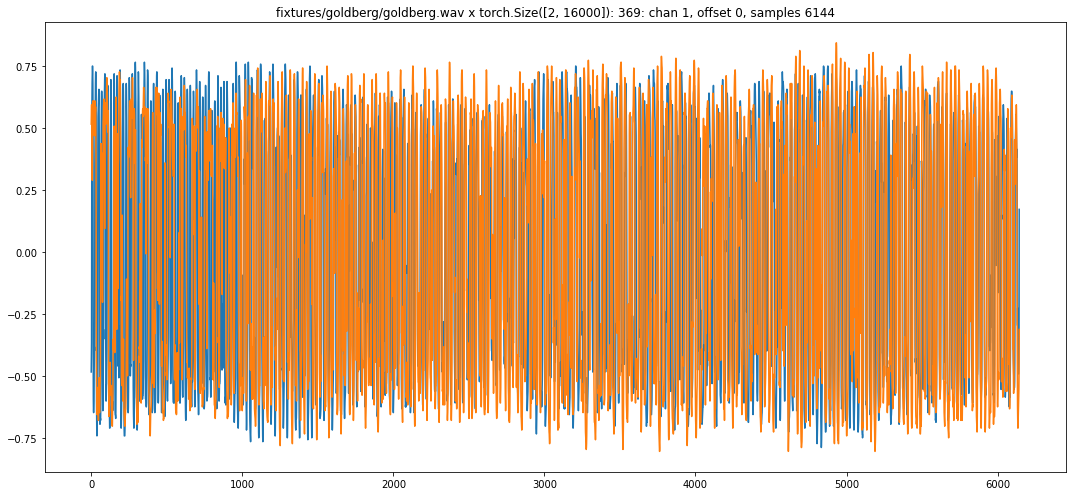

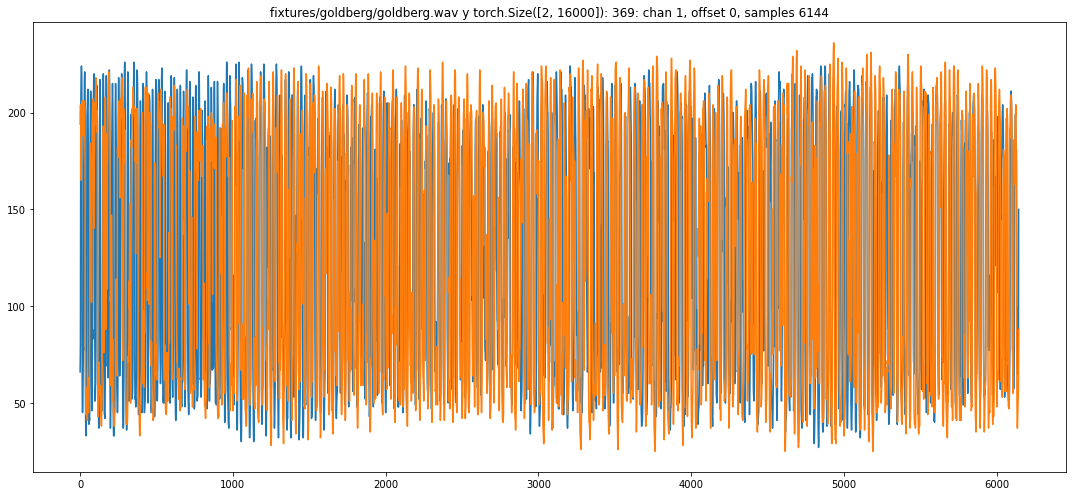

In [8]:
tracks_dataset(compress=True, n_classes=2**8)

# Sines Dataset

A dataset of sine waves. Let's begin by superimposing some samples, where the number of total samples is low ~200 and the sampling rate is very high, and thus able to capture high frequencies at this resolution.

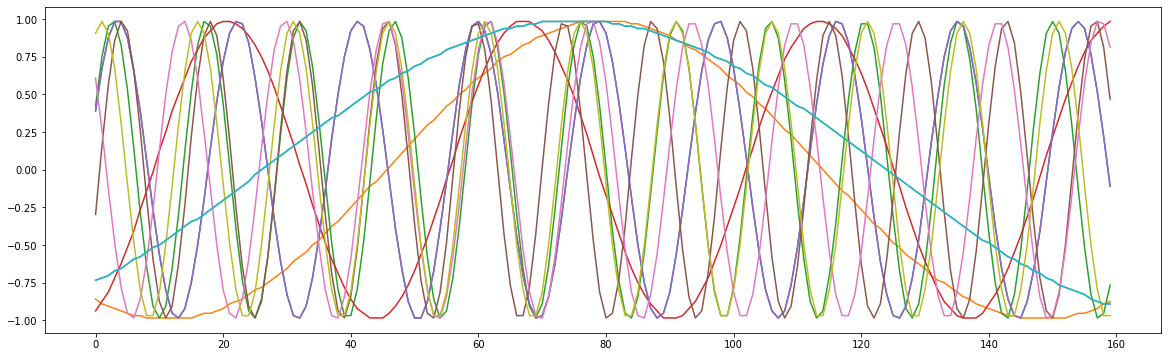

In [9]:
p = model.HParams(
    compress=False, 
    n_classes=2**7, 
    sample_length=160, 
    sampling_rate=2**18
)

def sines_dataset_superimposed(ds):
    plt.figure(figsize=(20, 6))
    for i in range(len(ds)):
        i, (x, y) = ds.sample()
        plt.plot(x[0, :])
    
sines_dataset_superimposed(datasets.Sines(10, p, amp=1.))

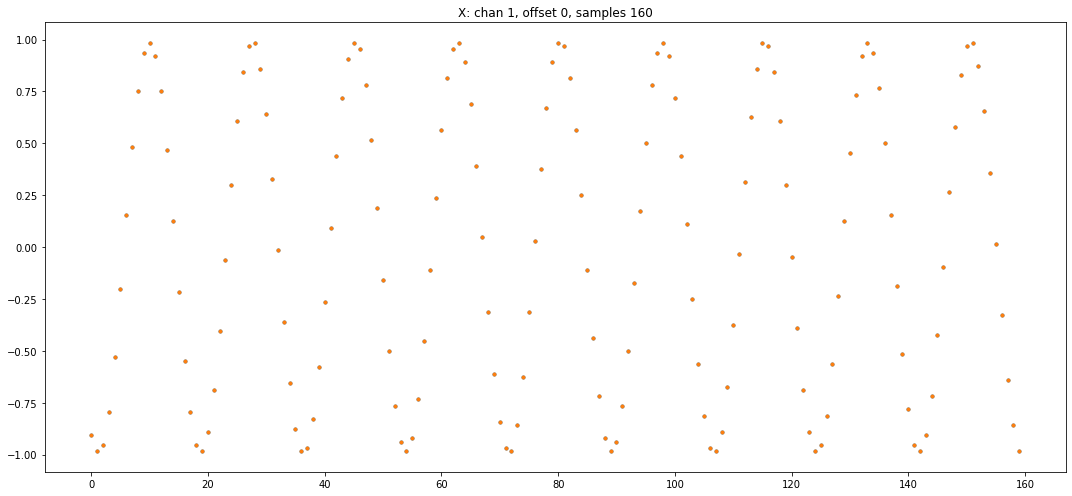

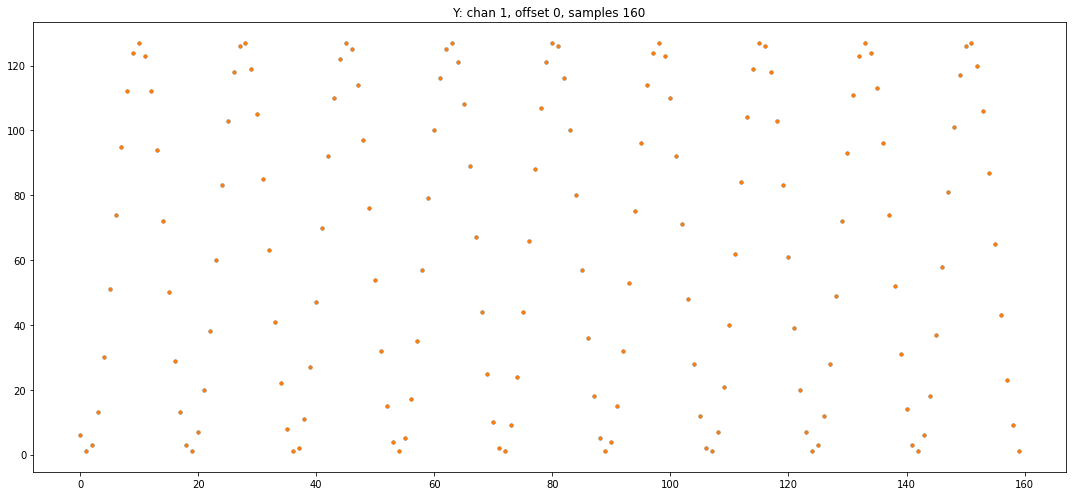

In [10]:
def sines_dataset(ds):
    i, (x, y) = ds.sample()
    viz.plot_track(x, n_samples=p.sample_length, title='X', style='.')
    viz.plot_track(y, n_samples=p.sample_length, title='Y', style='.')
    
sines_dataset(datasets.Sines(10, p, amp=1.))

In [11]:
def sines_dataset_listen(ds):
    for i in range(2):
        _, (x, y) = ds.sample()
        display(ipd.Audio(x[i], rate=p.sampling_rate))
        
p.sample_length = 160000
sines_dataset_listen(datasets.Sines(10, p, amp=1.))

## Tiny dataset

X
tensor([[-0.2685, -0.2685, -0.2685, -0.2685, -0.4796, -0.4796, -0.4796, -0.6906,
         -0.6906, -0.6906, -0.9017, -0.9017, -0.9017, -1.1127, -1.1127, -1.1127,
         -1.3238, -1.3238, -1.3238, -1.5348, -1.5348, -1.5348, -1.5348, -1.7459,
         -1.7459, -1.7459, -1.9570, -1.9570, -1.9570, -2.1680]])
Y
tensor([[30, 30, 30, 30, 29, 29, 29, 28, 28, 28, 27, 27, 27, 26, 26, 26, 25, 25,
         25, 24, 24, 24, 24, 23, 23, 23, 22, 22, 22, 21]])


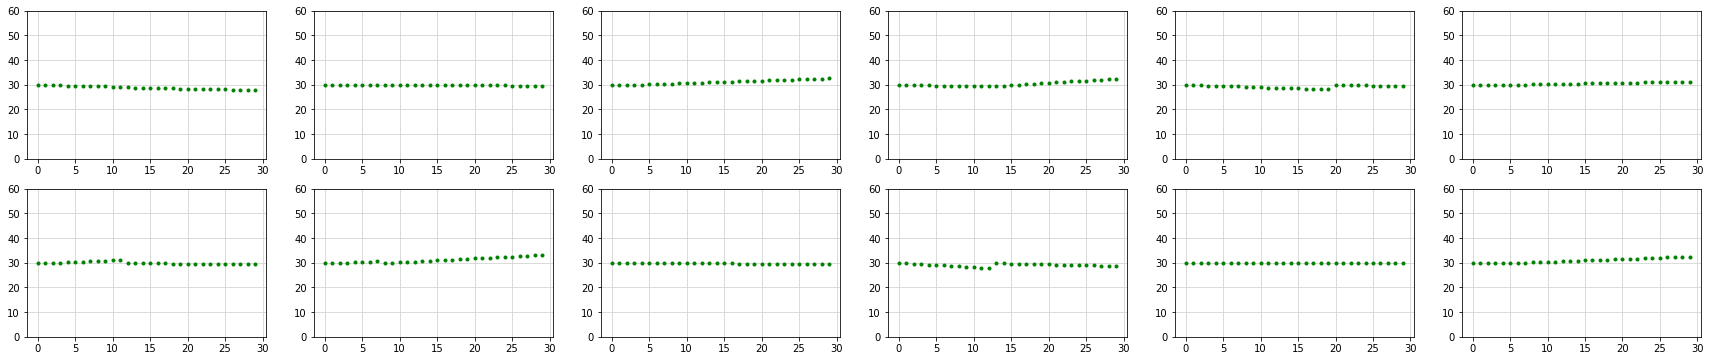

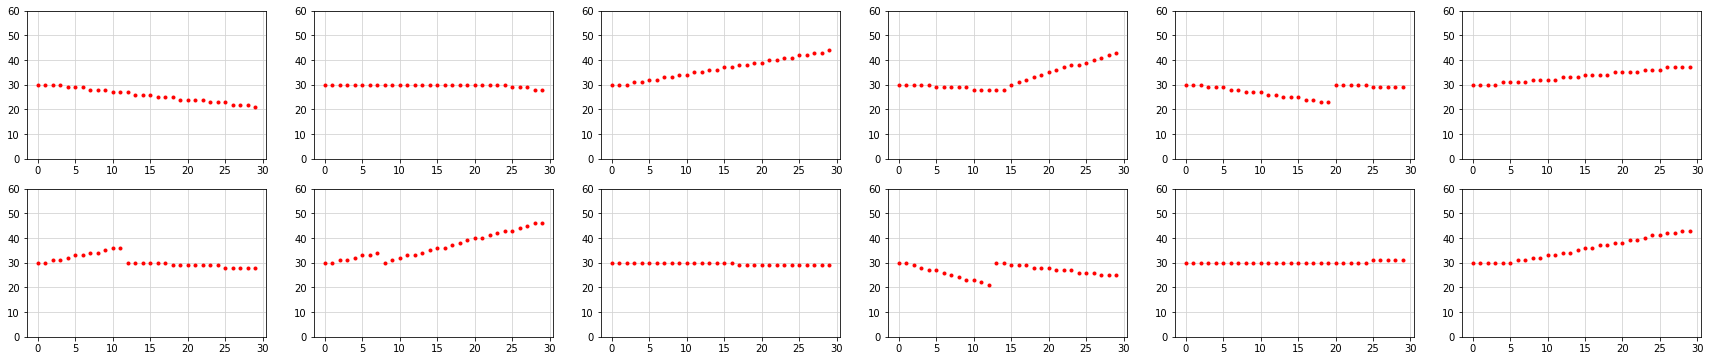

In [12]:
def tiny_datset(n, m):
    p = model.HParams(compress=False, n_classes=2*n, sample_length=n)
    utils.seed(p)
    ds = datasets.Tiny(n, m)
    return datasets.to_tensor(ds), p


def tiny(n, m):
    (X, Y), p = tiny_datset(n, m)
    print('X')
    print(X[0])
    print('Y')
    print(Y[0])
    
            
    plt.subplots(figsize=(30, 6))
    for i in range(m):
        plt.subplot(2, 6, i+1)
        plt.ylim(0, 2*n)
        plt.grid(color='lightgray')
        plt.plot(torch.arange(n), X[i].squeeze() + n, '.', color='green')
        
    plt.subplots(figsize=(30, 6))
    for i in range(m):
        plt.subplot(2, 6, i+1)
        plt.ylim(0, 2*n)
        plt.grid(color='lightgray')
        plt.plot(torch.arange(n), Y[i].squeeze(), '.', color='red')

        
tiny(n=30, m=12)